In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)


In [4]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) 
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [106]:
n_embd = 10
n_hidden = 200
#neatly written up
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),            generator=g)
W1 = torch.randn((n_embd*block_size ,n_hidden), generator=g) * (5/3)/(n_embd*block_size)**0.5
# b1 = torch.randn((n_hidden),                    generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.01
b2 = torch.randn((vocab_size),                  generator=g) * 0

#BatchNorm Parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running =  torch.ones((1, n_hidden))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]


In [107]:
sum(p.nelement() for p in parameters)

12297

In [108]:
for p in parameters:
    p.requires_grad = True

In [109]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # construct a mini batch
    ix = torch.randint(0, Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    #forward pass
    emb = C[Xb] #(32,3,2)
    embcat = emb.view(emb.shape[0],30) # concatenate the vectors
    hpreact = embcat@W1 #+ b1 # pre activation hidden layer
    #BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmeani)/bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running =  0.999*bnstd_running + 0.001 * bnstdi

    #Non linearity
    h = torch.tanh(hpreact) # hidden layer output
    logits = h@W2 +b2 #output layer
    loss = F.cross_entropy(logits,Yb) #loss function
    # print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = 0.1 if i<100_000 else 0.01 #step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    #track stats
    if i%10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    # lri.append(lr)
    # stepi.append(i)
    lossi.append(loss.log10().item())
    # break
# print(loss.item()) 


      0/ 200000: 3.3214
  10000/ 200000: 2.2015
  20000/ 200000: 2.4453
  30000/ 200000: 1.9793
  40000/ 200000: 1.9043
  50000/ 200000: 2.2204
  60000/ 200000: 2.1793
  70000/ 200000: 2.8445
  80000/ 200000: 2.1997
  90000/ 200000: 2.5277
 100000/ 200000: 2.2311
 110000/ 200000: 2.2620
 120000/ 200000: 2.1202
 130000/ 200000: 2.1176
 140000/ 200000: 1.9714
 150000/ 200000: 2.2228
 160000/ 200000: 1.6981
 170000/ 200000: 1.8255
 180000/ 200000: 2.3311
 190000/ 200000: 2.1667


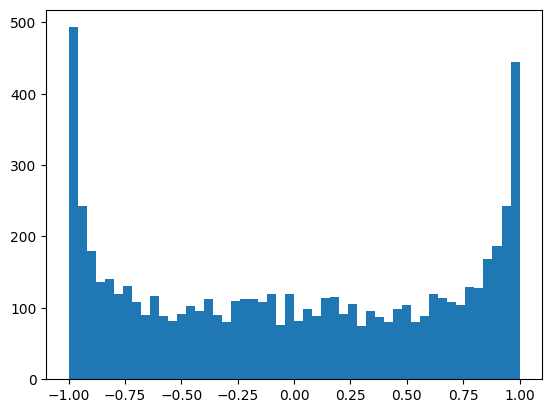

In [110]:
plt.hist(h.view(-1).tolist(),50);

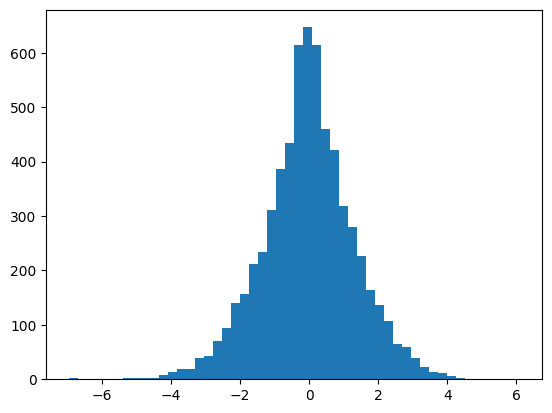

In [111]:
plt.hist(hpreact.view(-1).tolist(),50);

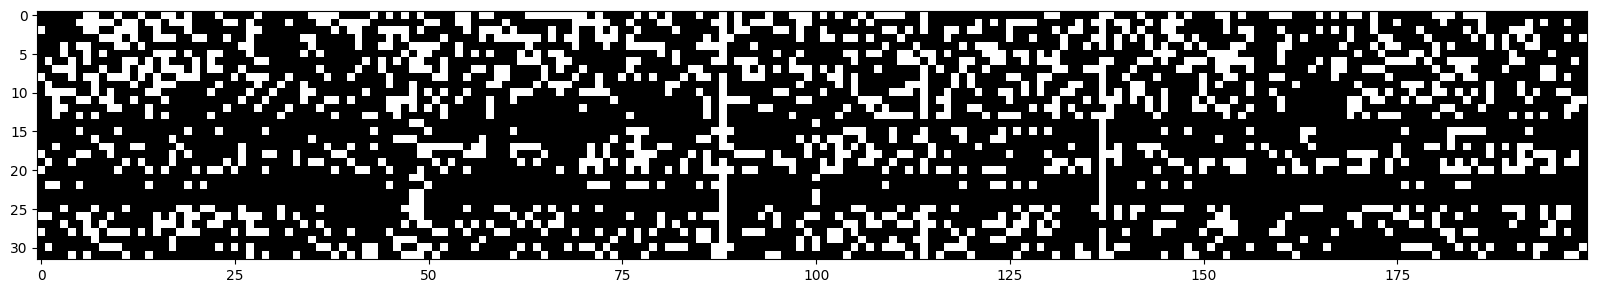

In [113]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.9, cmap='gray', interpolation='nearest')

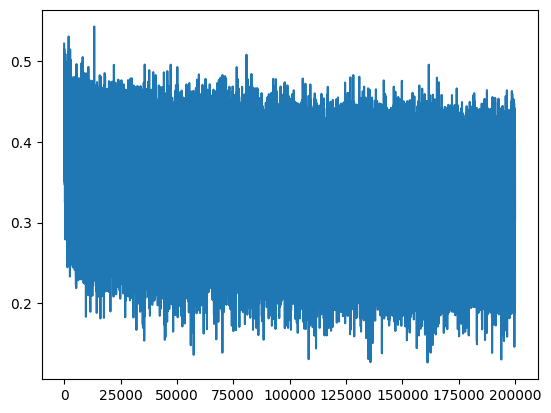

In [114]:
plt.plot(lossi)

In [115]:
@torch.no_grad() #disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat@W1 + b1
    hpreact = bngain*(hpreact - bnmean_running)/bnstd_running +bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    print(h.shape)
    logits = h@W2 +b2 #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')

torch.Size([182625, 200])
train 2.067248821258545


In [31]:
#inference:
for i in range(20):
    out = []
    context = [0]*block_size #ie ...
    while True:
        #get embeddings 
        emb = C[torch.tensor([context])] #shape is (1,block_size,d) where d is embedding size
        h = torch.tanh(emb.view(1,-1)@W1 +b1)
        logits = h@W2 +b2
        prob = logits.softmax(dim=1)
        ix = torch.multinomial(prob,num_samples=1).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    name = ''.join(itos[i] for i in out)
    print(name)


anderrik.
alahan.
kesamarivia.
rishauna.
naleigh.
satalee.
hemarshee.
widhkalis.
moralian.
haniy.
jamis.
nel.
vaide.
loc.
audeyson.
daree.
emushan.
jhelle.
harethea.
krizon.


In [ ]:
#SUMMARY

In [ ]:
#Let's train a deeper network
